# Lab.ipynb

This notebook is essentially a testing lab where I train the model, experiment with the model, and collect metrics. This is not intended
to be an organized summary of the results.

In [61]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Decision Tree Classifier

In [62]:
def get_x_and_y(dataset: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    x = dataset.drop(['label'], axis=1)
    y = dataset['label']
    y = (y == 'game')

    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.transform(y)

    return x, y, label_encoder

In [63]:
df = pd.read_csv("new_data.csv")

train, test = train_test_split(df, test_size=0.2, random_state=42)

x_train, y_train, label_encoder = get_x_and_y(train)
x_test, y_test, label_encoder = get_x_and_y(test)

In [64]:
tree_classifier = DecisionTreeClassifier(max_depth=13, random_state=42)
tree_classifier.fit(x_train, y_train)

y_predicted = tree_classifier.predict(x_train)

acc = accuracy_score(y_train, y_predicted)

print(f'Train error: {acc*100:.2f}%')

y_predicted = tree_classifier.predict(x_test)
acc = accuracy_score(y_test, y_predicted)

print(f'Test error: {acc*100:.2f}%')

import skops.io as sio
obj = sio.dump(tree_classifier, 'model.skops')

Train error: 99.96%
Test error: 95.56%


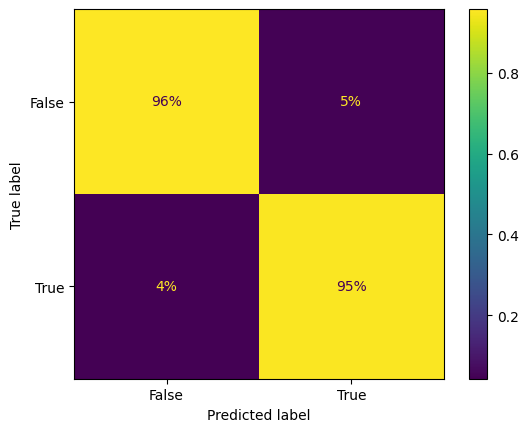

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, normalize='pred', values_format=".00%", display_labels=label_encoder.classes_)
plt.show()

In [66]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'f1: {f1*100:.2f}')

Precision: 95.36%
Recall: 95.36%
f1: 95.36


Current model has low false positives (high precision) and can identify 95% of the data points that are games.

# Cross validation 

In [67]:
from sklearn.model_selection import cross_val_score

full_x, full_y, label_encoder = get_x_and_y(df)

precision = cross_val_score(tree_classifier, full_x, full_y, cv=5, scoring='precision')
recall = cross_val_score(tree_classifier, full_x, full_y, cv=5, scoring='recall')
f1 = cross_val_score(tree_classifier, full_x, full_y, cv=5, scoring='f1')

print(f'Cross validated precision: {precision}')
print(f'Cross validated recall: {recall}')
print(f'Cross validated f1: {f1}')

Cross validated precision: [0.87782805 0.96350365 0.72849462 0.95703125 0.9298893 ]
Cross validated recall: [0.67595819 0.91986063 0.94755245 0.85365854 0.87804878]
Cross validated f1: [0.76377953 0.94117647 0.82370821 0.90239411 0.90322581]


Over 5-fold cross validation on the entire dataset our precision varies by quite a bit, sometimes
dropping to 72%

# Most important features

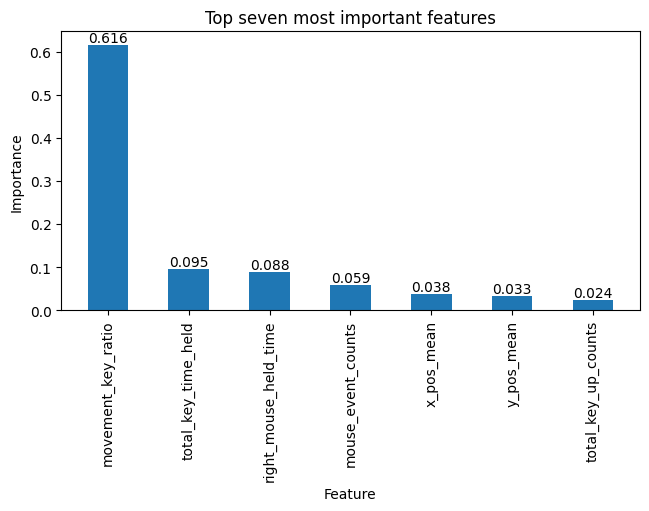

{'movement_key_ratio': np.float64(0.61609934648289),
 'total_key_time_held': np.float64(0.09546598750997796),
 'right_mouse_held_time': np.float64(0.08757706389169118),
 'mouse_event_counts': np.float64(0.058892709471224845),
 'x_pos_mean': np.float64(0.03821480748035299),
 'y_pos_mean': np.float64(0.032623644187914566),
 'total_key_up_counts': np.float64(0.02385664475525199),
 'alnum_keys_in_q1': np.float64(0.014571492988116093),
 'keyup_keys_in_q1': np.float64(0.01226474344781239),
 'left_mouseup_counts': np.float64(0.006819129040202189),
 'left_mouse_held_time': np.float64(0.0059606032595761384),
 'x_pos_stdev': np.float64(0.0034445499221549642),
 'y_pos_std_dev': np.float64(0.002066702141337828),
 'middle_mouse_held_time': np.float64(0.0012855452528981609),
 'right_mouseup_counts': np.float64(0.000857030168598774),
 'middle_mouseup_counts': np.float64(0.0),
 'key_held_keys_in_q1': np.float64(0.0)}

In [68]:
feature_names = x_test.columns.values.tolist()
importance = tree_classifier.feature_importances_

importance_dict = dict(sorted(dict(zip(feature_names, importance)).items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots()

def truncate(x):
    return f'{x:.3f}'

bars = ax.bar(np.arange(7), list(importance_dict.values())[:7], width=0.5)
ax.bar_label(bars, map(truncate, list(importance_dict.values())[:7]))

ax.set_xticks(np.arange(7), list(importance_dict.keys())[:7], rotation='vertical')

fig.tight_layout()

ax.set_title('Top seven most important features')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')

plt.show()

importance_dict

## Summary

Movement key ratio is the most important feature. This means that games that rely
on many keys and not just movement keys (WASD and arrow keys) may not be detected.

In our case this would result in high false negatives but I infer that it will not
result in a lot of false positives, since most work activites involve typing
and using multiple keys. We would want more false negatives if it means lower
false positives.

Other than movement key, total key time held, right mouse time held, and mouse
event counts are the most important.

# Incorrect values

In [69]:
y_predicted = tree_classifier.predict(x_test)

true_positive = []
true_negative = []
false_positive = []
false_negative = []

for i, actual in enumerate(y_test):
    pred = y_predicted[i]
    features = x_test.iloc[i]

    if pred != actual:
        # False
        if pred:
            # False positive
            false_positive.append(features)
        else:
            # False negative
            false_negative.append(features)
    
    else:
        # True

        if pred:
            # True positive
            true_positive.append(features)
        else:
            # True negative
            true_negative.append(features)
        

true_positive = pd.DataFrame(true_positive)
true_negative = pd.DataFrame(true_negative)
false_positive = pd.DataFrame(false_positive)
false_negative = pd.DataFrame(false_negative)

## True positives, false positives, and true negative

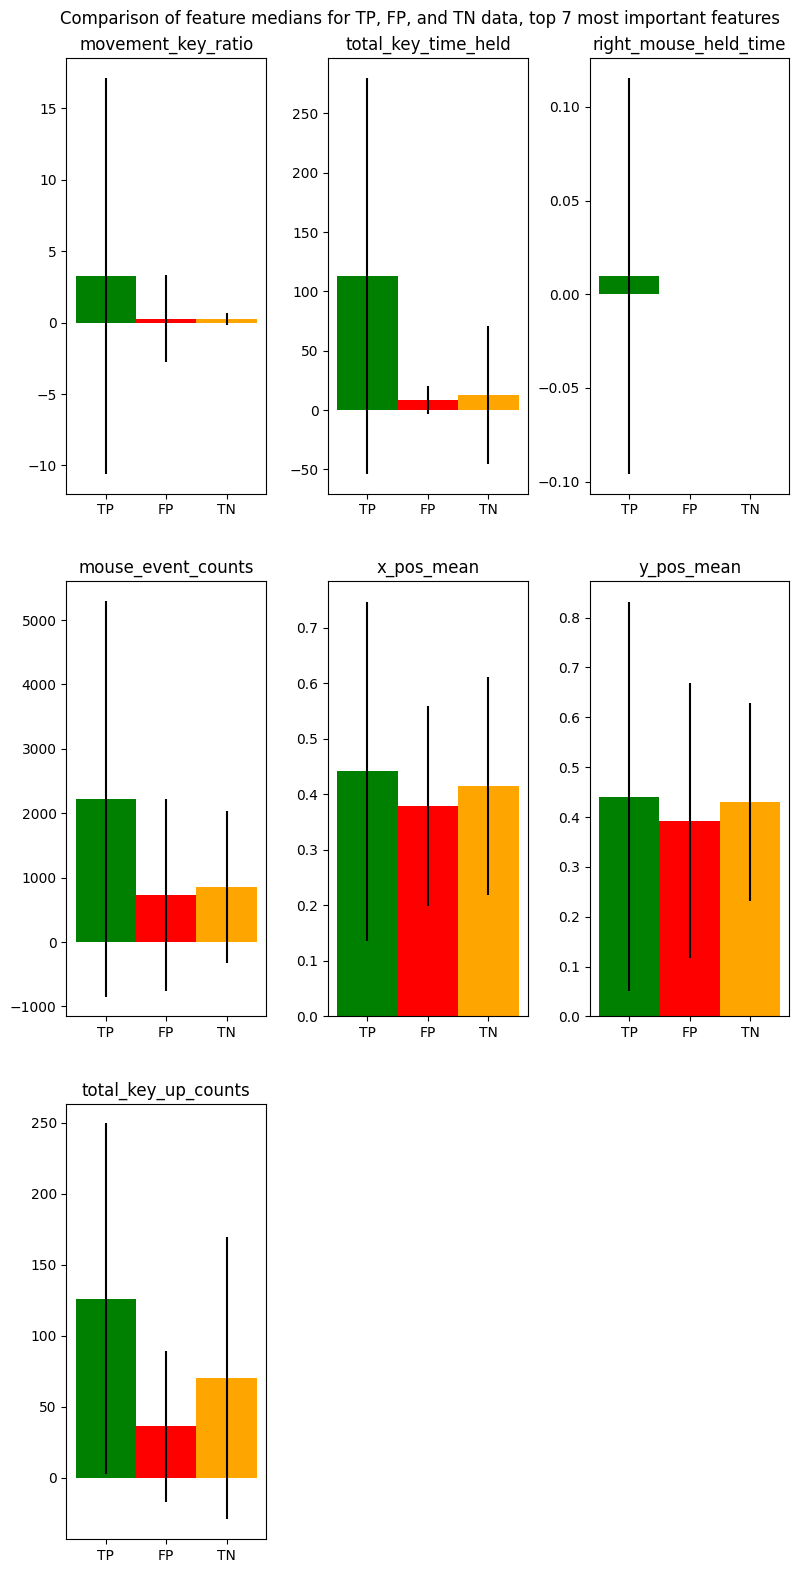

In [70]:
true_positive_medians = true_positive.median()
false_positive_medians = false_positive.median()
true_negative_medians = true_negative.median()

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 16))
fig.suptitle('Comparison of feature medians for TP, FP, and TN data, top 7 most important features')
fig.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.2)


print()
print()

width = 0.5

most_important_features = list(importance_dict.keys())[:7]

for i, feature in enumerate(most_important_features):
    true_positive_value = true_positive_medians.loc[feature]
    false_positive_value = false_positive_medians.loc[feature]
    true_negative_value = true_negative_medians.loc[feature]

    ax[i//3][i%3].bar(0, true_positive_value, width=width, color='green', yerr=true_positive[feature].quantile(0.75)-true_positive[feature].quantile(0.25))
    ax[i//3][i%3].bar(width, false_positive_value, width=width, color='red', yerr=false_positive[feature].quantile(0.75)-false_positive[feature].quantile(0.25))
    ax[i//3][i%3].bar(width*2, true_negative_value, width=width, color='orange', yerr=true_negative[feature].quantile(0.75)-true_negative[feature].quantile(0.25))

    ax[i//3][i%3].set_title(feature)
    ax[i//3][i%3].set_xticks([0, width, width*2], ['TP', 'FP', 'TN'])

fig.delaxes(ax[2][-2])
fig.delaxes(ax[2][-1])

plt.show()

## Summary

The above graph is a set of 7 subplots. Each subplot is focused around a single 
feature, which is indicated at the top of the subplot. Each subplot has three 
bars, each one representing a different subset of the test data. Data is split
into whether it was true positive (TP), false positive (FP), or true negative (TN).
The value of the bars show the median for that feature and subgroup, and the error
bars is the interquartile range (IQR) for that subgroup. Median and IQR are used due to the large outliers
of the dataset. 

The median false positive values for almost all features except y_pos_mean tend to 
follow the trend as true negative values. Thus, we may find the false positives
unexpected, as from the medians alone the false positive data seems to be similar
to true negative data. However, given the high variance and high IQR, the medians
do not represent the groups accurately.

I infer that because of the high variance of the features, the model is unable to
generalize for the data in the false positive group and so failed to accurately
predict for those data.

# Comparison with DummyClassifier

In [71]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(x_train, y_train)

y_predicted = dummy_clf.predict(x_test)

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'f1: {f1*100:.2f}')

Precision: 44.14%
Recall: 45.71%
f1: 44.91


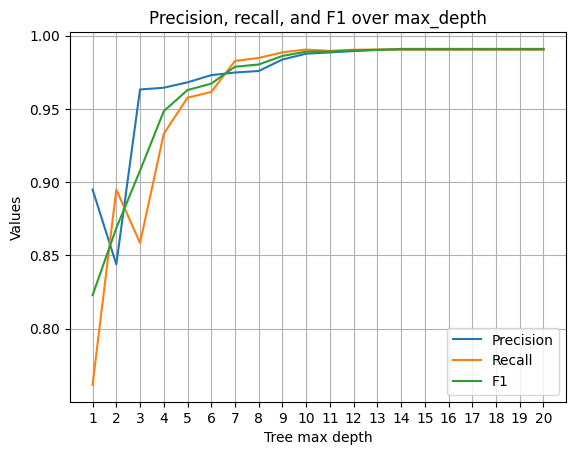

In [72]:
precision_scores = [0 for x in range(21)]
recall_scores = [0 for x in range(21)]
f1 = [0 for x in range(21)]

MAX_STATES = 50


for state in range(0, MAX_STATES):
    for depth in range(1, 21):
        train, test = train_test_split(df, test_size=0.5, random_state=state)
        x_test, y_test, label_encoder = get_x_and_y(test)

        tree_classifier = DecisionTreeClassifier(max_depth=depth, random_state=state)
        tree_classifier.fit(x_train, y_train)

        y_predicted = tree_classifier.predict(x_test)

        precision_scores[depth] += (precision_score(y_test, y_predicted))
        recall_scores[depth] += (recall_score(y_test, y_predicted))
        f1[depth] += (f1_score(y_test, y_predicted))

precision_scores = [i/MAX_STATES for i in precision_scores][1:]
recall_scores = [i/MAX_STATES for i in recall_scores][1:]
f1 = [i/MAX_STATES for i in f1][1:]

fig, ax = plt.subplots()

ax.plot(list(range(1, 21)), precision_scores, label='Precision')
ax.plot(list(range(1, 21)), recall_scores, label='Recall')
ax.plot(list(range(1, 21)), f1, label='F1')
ax.grid(visible=True)
ax.set_xticks(np.arange(1, 21, 1))
ax.legend()
ax.set_title('Precision, recall, and F1 over max_depth')
ax.set_xlabel('Tree max depth')
ax.set_ylabel('Values')
plt.show()
